In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Packages

In [2]:
!pip install keybert
!python -m spacy download en_core_web_md
!pip install flair
!pip install textacy
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import spacy
import re
nlp = spacy.load("en_core_web_sm")
import textacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from keybert import KeyBERT
from flair.data import Sentence
from flair.models import SequenceTagger
ner_tagger = SequenceTagger.load("flair/ner-english")
pos_tagger = SequenceTagger.load("flair/pos-english")
with open("/content/drive/MyDrive/Mencius_research/Mencius_research/extra_stopwords.txt", 'rt') as f:
  extra_stopword_list = [t.replace("\n",'') for t in f.readlines()]
stop_words = list(set(stopwords.words('english')))+extra_stopword_list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.8 MB/s 
     |████████████████████████████████| 238 kB 65.9 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 
     |████████████████████████████████| 5.8 MB 58.6 MB/s 
     |████████████████████████████████| 1.3 MB 60.3 MB/s 
     |████████████████████████████████| 182 kB 74.7 MB/s 
     |████████████████████████████████| 7.6 MB 53.1 MB/s 
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23800 sha256=860ca9b8a29015ba9fda40b43d43dbc3d3aab0db56b501817642757d0fb62a58
  Stored in directory: /root/.cache/pip/wheels/6c/bc/8b/a51bee77aec33895e6c8c236144b4cc10875659c4d2c80f070
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=151ad987eb9b47af8b6fc55c4ca5d61637235a0487ac8a3ebd0e46fc29c763a8
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloa

Downloading:   0%|          | 0.00/432M [00:00<?, ?B/s]

2022-12-31 07:17:35,174 loading file /root/.flair/models/ner-english/4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2022-12-31 07:17:37,649 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


Downloading:   0%|          | 0.00/249M [00:00<?, ?B/s]

2022-12-31 07:17:47,588 loading file /root/.flair/models/pos-english/a9a73f6cd878edce8a0fa518db76f441f1cc49c2525b2b4557af278ec2f0659e.121306ea62993d04cd1978398b68396931a39eb47754c8a06a87f325ea70ac63
2022-12-31 07:17:47,755 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


In [3]:
#맹자남은부분-파란색
with open("/content/drive/MyDrive/Mencius_research/Mencius_research/not_deleted_dict_structure.pickle",'rb') as f:
 mencius_not_deleted = pickle.load(f)

#맹자삭제된부분-빨간색
with open("/content/drive/MyDrive/Mencius_research/Mencius_research/deleted_dict_structure.pickle",'rb') as f:
 mencius_deleted = pickle.load(f)

# Preprocessing Function

In [4]:
def new_pos_tagger(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('N'):
    return wordnet.NOUN
  elif tag.startswith('R'):
    return wordnet.ADV

def preprocessing(input_text): #mencius_not_deleted 또는 mencius_deleted
  text_full = '' #삭제안한부분에 대한 모든 내용
  for t in input_text.keys():
    for k in input_text[t].keys():
      for j,v in input_text[t][k].items():
        text_full  += ' ' + v

  # 텍스트 내용에 포함된 목차와 불필요한 특수기호 삭제 
  
  roman = list(mencius_not_deleted.keys()) #I, II, III, IV...
  for r in roman:
    text_full = re.sub(f'\\b{r}\\b',' ',text_full)
  mid_heading = []                         #Gong Sun Chou I, ... 
  for k in mencius_not_deleted.keys():
    mid_heading.extend(list(mencius_not_deleted[k].keys()))
  for m in mid_heading:
    text_full = re.sub(f'\\b{m}\\b',' ',text_full)
  text_full = text_full.replace('·',' ').strip()  #불필요한 특수기호

  #개체명인식을 이용하여 사람 이름을 모두 제거
  for p in ner_name:
    text_full = re.sub(f'\\b{p}\\b',' ',text_full)

  #전체 텍스트 소문자 변환
  text_full = text_full.lower()

  #텍스트 정규화(같은 의미의 서로 다른 단어를 하나로 통일)
  text_full = re.sub(r'\bduke\b|\bmajesty(\'s|s)?\b|\bson of heaven\b|\b(royal\s*)?sovereigns?\b|\bprince(\s*of\s*ten\s*thousand\s*chariots|s)?\b|\b(royal\s*)?ruler\b|\bmonarchs?\b|\b(royal\s*)?kings?\b','king',text_full)
  text_full = re.sub(r'\bfillial\s*piety\b','fillial',text_full)
  text_full = re.sub(r'\b(little|small|country|inferior|low)\s*(m(e|a)n|people)\b','inferior man',text_full)
  text_full = re.sub(r'\b(high\s*)?ministers?\b|\bofficers?\b','officer',text_full)
  text_full = re.sub(r'\bstates?\b|\bgovernments?\b|\b(kingdom|country)\s*of\s*ten\s*thousand\s*chariots\b','kingdom',text_full)
  text_full = text_full.replace('viscount','noble').replace('country','kingdom')
  text_full = re.sub(r'\bsuperior\s*m(a|e)n\b|\bgood\s*m(a|e)n\b|\bmen\s*of\s*a\s*superior\s*grade\b','superior man',text_full)
  text_full = re.sub(r'\bmen\b|\bwomen\b','people',text_full)
  text_full = re.sub(r'\breign\b|\bgovern\b|\bt(ook|ake)\s*office','govern',text_full)

  doc=nlp(text_full)
  patterns = ["POS:ADJ POS:NOUN:+"]
  spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
  noun_phrase=[s.lemma_ for s in spans]
  noun_phrase=list(set(noun_phrase))
  for n in noun_phrase:
    phrase=str(n).replace(" ","-")
    text_full = re.sub(f"\\b{n}\\b", phrase, text_full)

  #토큰화
  text_full = word_tokenize(text_full)

  #형태소 분석
  text_full = nltk.pos_tag(text_full)
  text_full = list(map(lambda x: (x[0], new_pos_tagger(x[1])), text_full))
  text_full = [w for w, t in text_full if t in ['n','a','v']]

  #형용사, 명사, 동사 단어에 대한 표제어 추출
  lemmatized_text = []
  for w in text_full:
    if '-' in w:
      word = w.replace("-",'')
      lemmatized_text.append(word) #word
    else:
      for tok in nlp(w):
        lemmatized_text.append(tok.lemma_)
  text_full = [str(w) for w in lemmatized_text]

  #불용어 제거
  text_full = [w for w in text_full if  w not in stop_words]
  text_full = ' '.join(text_full)
  text_full = re.sub(r'(much|more|most|such)','',text_full)

  return text_full

In [5]:
def part_preprocessor(text_full): #input text which is a string type
  # 텍스트 내용에 포함된 목차와 불필요한 특수기호 삭제 
  roman = list(mencius_not_deleted.keys()) #I, II, III, IV...
  for r in roman:
    text_full = re.sub(f'\\b{r}\\b',' ',text_full)
  mid_heading = []                         #Gong Sun Chou I, ... 
  for k in mencius_not_deleted.keys():
    mid_heading.extend(list(mencius_not_deleted[k].keys()))
  for m in mid_heading:
    text_full = re.sub(f'\\b{m}\\b',' ',text_full)
  text_full = text_full.replace('·',' ').strip()  #불필요한 특수기호

  #개체명인식을 이용하여 사람 이름을 모두 제거
  for p in ner_name:
    text_full = re.sub(f'\\b{p}\\b',' ',text_full)

  #전체 텍스트 소문자 변환
  text_full = text_full.lower()

  #텍스트 정규화(같은 의미의 서로 다른 단어를 하나로 통일)
  text_full = re.sub(r'\bduke\b|\bmajesty(\'s|s)?\b|\bson of heaven\b|\b(royal\s*)?sovereigns?\b|\bprince(\s*of\s*ten\s*thousand\s*chariots|s)?\b|\b(royal\s*)?ruler\b|\bmonarchs?\b|\b(royal\s*)?kings?\b','king',text_full)
  text_full = re.sub(r'\bfillial\s*piety\b','fillial',text_full)
  text_full = re.sub(r'\b(little|small|country|inferior|low)\s*(m(e|a)n|people)\b','inferior man',text_full)
  text_full = re.sub(r'\b(high\s*)?ministers?\b|\bofficers?\b','officer',text_full)
  text_full = re.sub(r'\bstates?\b|\bgovernments?\b|\b(kingdom|country)\s*of\s*ten\s*thousand\s*chariots\b','kingdom',text_full)
  text_full = text_full.replace('viscount','noble').replace('country','kingdom')
  text_full = re.sub(r'\bsuperior\s*m(a|e)n\b|\bgood\s*m(a|e)n\b|\bmen\s*of\s*a\s*superior\s*grade\b','superior man',text_full)
  text_full = re.sub(r'\bmen\b|\bwomen\b','people',text_full)
  text_full = re.sub(r'\breign\b|\bgovern\b|\bt(ook|ake)\s*office','govern',text_full)

  doc=nlp(text_full)
  patterns = ["POS:ADJ POS:NOUN:+"]
  spans = textacy.extract.matches.token_matches(doc, patterns=patterns)
  noun_phrase=[s.lemma_ for s in spans]
  noun_phrase=list(set(noun_phrase))
  for n in noun_phrase:
    phrase=str(n).replace(" ","-") 
    text_full = re.sub(f"\\b{n}\\b", phrase, text_full)


  #토큰화
  text_full = word_tokenize(text_full)

  #형태소 분석
  text_full = nltk.pos_tag(text_full)
  text_full = list(map(lambda x: (x[0], new_pos_tagger(x[1])), text_full))
  text_full = [w for w, t in text_full if t in ['n','a','v']]


  #형용사, 명사, 부사 단어에 대한 표제어 추출
  lemmatized_text = []
  for w in text_full:
    if '-' in w:
      word = w.replace("-",'')
      lemmatized_text.append(word) #word
    else:
      for tok in nlp(w):
        lemmatized_text.append(tok.lemma_)
  text_full = [str(w) for w in lemmatized_text]


  #불용어 제거
  text_full = [w for w in text_full if w not in stop_words]
  text_full = ' '.join(text_full)
  text_full = re.sub(r'(much|more|most|such)','',text_full)
  
  return text_full

# Extract Names by 'Named Entity Recognition'

In [6]:
not_deleted_text_full = '' #삭제안한부분에 대한 모든 내용
for t in mencius_not_deleted.keys():
  for k in mencius_not_deleted[t].keys():
    for j,v in mencius_not_deleted[t][k].items():
      not_deleted_text_full  += ' '+v

# 텍스트 내용에 포함된 목차와 불필요한 특수기호 삭제 
roman = list(mencius_not_deleted.keys()) #I, II, III, IV...
for r in roman:
  not_deleted_text_full = re.sub(f'\\b{r}\\b',' ',not_deleted_text_full)
mid_heading = []                         #Gong Sun Chou I, ... 
for k in mencius_not_deleted.keys():
  mid_heading.extend(list(mencius_not_deleted[k].keys()))
for m in mid_heading:
  not_deleted_text_full = re.sub(f'\\b{m}\\b',' ',not_deleted_text_full)
not_deleted_text_full = not_deleted_text_full.replace('·',' ').strip()  #불필요한 특수기호

#개체명인식을 이용하여 사람 이름을 모두 제거
sentence = Sentence(not_deleted_text_full)
ner_tagger.predict(sentence)
ner_tagged=[(label.data_point.text, label.value) for label in sentence.get_labels('ner')]
per_tagged = [(tup[0],tup[1]) for tup in ner_tagged if tup[1]=='PER']
per_tagged = [tup[0] for tup in per_tagged]
not_deleted_per_tagged_name = list(set(per_tagged))

In [7]:
deleted_text_full = '' #삭제한부분에 대한 모든 내용
for t in mencius_deleted.keys():
  for k in mencius_deleted[t].keys():
    for j,v in mencius_deleted[t][k].items():
      deleted_text_full  += ' '+v

# 텍스트 내용에 포함된 목차와 불필요한 특수기호 삭제 
roman = list(mencius_deleted.keys()) #I, II, III, IV...
for r in roman:
  deleted_text_full = re.sub(f'\\b{r}\\b',' ',deleted_text_full)
mid_heading = []                     #Gong Sun Chou I, ... 
for k in mencius_deleted.keys():
  mid_heading.extend(list(mencius_deleted[k].keys()))
for m in mid_heading:
  deleted_text_full = re.sub(f'\\b{m}\\b',' ',deleted_text_full)
deleted_text_full = deleted_text_full.replace('·',' ').strip()  #불필요한 특수기호

#개체명인식을 이용하여 사람 이름을 모두 제거
sentence = Sentence(deleted_text_full)
ner_tagger.predict(sentence)
ner_tagged=[(label.data_point.text, label.value) for label in sentence.get_labels('ner')]
per_tagged = [(tup[0],tup[1]) for tup in ner_tagged if tup[1]=='PER']
per_tagged = [tup[0] for tup in per_tagged]
deleted_per_tagged_name = list(set(per_tagged))

In [8]:
#삭제된부분과 삭제안된부분 모두에서 확인할 수 있는 사람 이름들
ner_name = [n for n in list(set(not_deleted_per_tagged_name + deleted_per_tagged_name)) if n not in ['Sage','Seek','Slay','Son of Heaven','Heaven','His Majesty','Majestys']]

# 1. Text Preprocessing

## 1.1. Preprocessing Not Deleted Part of Mencius

In [9]:
#무삭제 부분 전체 전처리
preprocessed_not_deleted = preprocessing(mencius_not_deleted)

In [10]:
#무삭제 단락별 전처리
not_deleted_texts = []
for n in mencius_not_deleted.keys():
  for j in mencius_not_deleted[n].keys():
    txt = ''    
    for a,b in mencius_not_deleted[n][j].items():
      txt += ' ' + b
    not_deleted_texts.append(txt)

not_deleted_texts = [not_deleted_texts[i]+' '+ not_deleted_texts[i+1] for i in range(len(not_deleted_texts)) if i%2==0]

not_deleted_texts_full = []
for i in range(len(not_deleted_texts)) :
  not_deleted_texts_full.append(part_preprocessor(not_deleted_texts[i]))

for i, v in enumerate(not_deleted_texts_full):
  globals()[f"not_deleted_{i+1}"] = v


## 1.2. Preprocessing Deleted Part of Mencius

In [11]:
#삭제 부분 전체 전처리
preprocessed_deleted = preprocessing(mencius_deleted)

In [12]:
#삭제 단락별 전처리
deleted_texts = []
for n in mencius_deleted.keys():
  for j in mencius_deleted[n].keys():
    txt = ''    
    for a,b in mencius_deleted[n][j].items():
      txt += ' ' + b
    deleted_texts.append(txt)

deleted_texts = [deleted_texts[i]+' '+ deleted_texts[i+1] for i in range(len(deleted_texts)) if i%2==0]

deleted_texts_full = []
for i in range(len(deleted_texts)) :
  deleted_texts_full.append(part_preprocessor(deleted_texts[i]))

for i, v in enumerate(deleted_texts_full):
  globals()[f"deleted_{i+1}"] = v

# 2. Topic Modeling


## 2.1. LDA Topic Modeling

### 2.1.1. LDA Topic Modeling - Not Deleted Part of Mencius

In [13]:
#LDA 는 Count기반의 Vectorizer만 적용합니다. 
count_vect = CountVectorizer(max_df=0.95, max_features=50, min_df=2, stop_words='english', ngram_range=(1,1))
feat_vect = count_vect.fit_transform(not_deleted_texts_full)
lda = LatentDirichletAllocation(n_components=5, random_state=50)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=5, random_state=50)

In [14]:
def display_topic_words(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('\nTopic #',topic_index+1)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ', '.join([str(feature_names[i]) for i in top_indexes])
        #feature_concat = ' + '.join([str(feature_names[i])+'*'+str(round(topic[i],1)) for i in top_indexes])                
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vect.get_feature_names()

# Topic별 가장 연관도가 높은 word를 10개만 추출
display_topic_words(lda, feature_names, 10)


Topic # 1
parent, superiorman, son, turn, father, speak, water, disciple, great, word

Topic # 2
scholar, office, officer, parent, desire, field, accord, order, receive, father

Topic # 3
good, mind, nature, righteousness, water, benevolence, officer, brother, great, eat

Topic # 4
eat, nourish, hand, grain, follow, superiorman, pursue, want, officer, mind

Topic # 5
superiorman, righteousness, scholar, sage, seek, desire, good, nature, eat, nourish


In [15]:
pyLDAvis.sklearn.prepare(lda, feat_vect, count_vect)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.089688 -0.021368       1        1  45.692220
0      0.027442  0.116049       2        1  27.265530
1     -0.190453 -0.023007       3        1  14.107862
4      0.070824 -0.080071       4        1  12.840471
3      0.002498  0.008398       5        1   0.093917, topic_info=           Term       Freq      Total Category  logprob  loglift
39      scholar  45.000000  45.000000  Default   30.000  30.0000
29       parent  54.000000  54.000000  Default   29.000  29.0000
43  superiorman  52.000000  52.000000  Default   28.000  28.0000
25       office  32.000000  32.000000  Default   27.000  27.0000
22         mind  37.000000  37.000000  Default   26.000  26.0000
..          ...        ...        ...      ...      ...      ...
40         seek   0.027724  33.533282   Topic5   -3.912  -0.1275
39      scholar   0.027724  45.535589   Topic5   -3.912  -0.4334
16        great   0.027724  43.619720   Topic5   -3.912  -0.3904
41          son   0.027724  32.917319   Topic5   -3.912  -0.1089
25       office   0.027724  32.674627   Topic5   -3.912  -0.1015

[204 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.437402   accord
0         2  0.198819   accord
0         3  0.357875   accord
0         4  0.039764   accord
1         1  0.380458  account
...     ...       ...      ...
48        2  0.434322     word
48        3  0.066819     word
48        4  0.200456     word
49        1  0.924739    young
49        3  0.051374    young

[165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

### 2.1.2. LDA Topic Modeling - Deleted Part of Mencius

In [16]:
#LDA 는 Count기반의 Vectorizer만 적용합니다. 
count_vect = CountVectorizer(max_df=0.95, max_features=50, min_df=2, stop_words='english', ngram_range=(1,1))
feat_vect = count_vect.fit_transform(deleted_texts_full) #deleted_texts_full
lda = LatentDirichletAllocation(n_components=5, random_state=50)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=5, random_state=50)

In [17]:
def display_topic_words(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('\nTopic #',topic_index+1)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ', '.join([str(feature_names[i]) for i in top_indexes])
        # feature_concat = ' + '.join([str(feature_names[i])+'*'+str(round(topic[i],1)) for i in top_indexes])                
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vect.get_feature_names()

# Topic별 가장 연관도가 높은 word를 10개만 추출
display_topic_words(lda, feature_names, 10)


Topic # 1
speak, word, mind, court, nature, serve, carry, hear, seek, leave

Topic # 2
present, heaven, scholar, office, virtue, throne, proper, govern, support, account

Topic # 3
love, music, death, pleasure, hear, kill, wife, brother, tell, desire

Topic # 4
benevolent, water, rule, family, heart, regard, leave, wife, hear, mean

Topic # 5
brother, eat, send, live, superiorman, support, carry, seek, mean, desire


In [18]:
pyLDAvis.sklearn.prepare(lda, feat_vect, count_vect)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.115883 -0.113519       1        1  27.846880
1     -0.071723  0.005186       2        1  27.139782
2      0.057152  0.165635       3        1  22.657159
3     -0.069376  0.040112       4        1  16.126282
4      0.199830 -0.097414       5        1   6.229896, topic_info=       Term       Freq      Total Category  logprob  loglift
2   brother  26.000000  26.000000  Default  30.0000  30.0000
8       eat  18.000000  18.000000  Default  29.0000  29.0000
27  present  28.000000  28.000000  Default  28.0000  28.0000
35     send  28.000000  28.000000  Default  27.0000  27.0000
16     live  16.000000  16.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
6     death   0.203141  28.900506   Topic5  -5.8638  -2.1819
37    speak   0.189203  27.882718   Topic5  -5.9349  -2.2171
15    leave   0.186292  27.836373   Topic5  -5.9504  -2.2310
36    serve   0.184402  26.935135   Topic5  -5.9606  -2.2083
11     hear   0.183873  40.393573   Topic5  -5.9635  -2.6164

[194 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.207369     account
0         2  0.518421     account
0         3  0.155526     account
0         4  0.155526     account
1         1  0.104879  benevolent
...     ...       ...         ...
48        4  0.346980        wife
49        1  0.715782        word
49        2  0.065071        word
49        3  0.065071        word
49        4  0.130142        word

[182 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

## 2.2 KeyBert Topic Modeling

In [19]:
#keybert 모델 불러오기
kw_model = KeyBERT()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

### 2.2.1. KeyBert Topic Modeling - Whole Text of Not Deleted Part of Mencius

<Keywords of Not Deleted Text>
('kingdom', 0.4729)
('largekingdom', 0.3163)
('worthyking', 0.2526)
('numerouspeople', 0.2337)
('impose', 0.1996)
('starve', 0.1884)
('care', 0.1712)
('glossedwickedness', 0.1691)
('select', 0.1558)
('sparesimplicity', 0.1544)





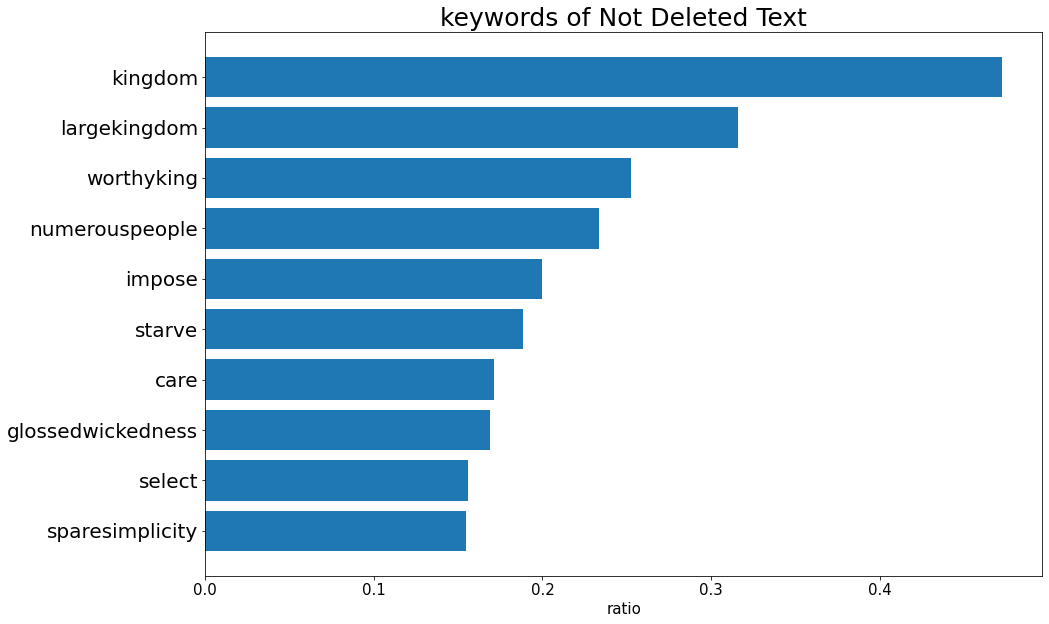

In [20]:
#무삭제 부분 전체 Keyword 10개 
keywords = kw_model.extract_keywords(preprocessed_not_deleted, stop_words='english', use_mmr = True, diversity = 0.4, top_n = 10)
print('<Keywords of Not Deleted Text>')
for k in keywords: print(k)
print('\n\n')
                         
x=np.arange(10)
words = list(reversed([k[0] for k in keywords]))
ratio = list(reversed([k[1] for k in keywords]))

plt.figure(figsize=(15,10))
plt.barh(x, ratio)
plt.yticks(x, words, fontsize=20)
plt.xticks(fontsize=15)
plt.xlabel('ratio', fontsize=15)
plt.title('keywords of Not Deleted Text', fontdict = {'fontsize':25})
plt.show()


### 2.2.2. KeyBert Topic Modeling - Whole Text of Deleted Part of Mencius

<Keywords of Deleted Text>
('king', 0.5207)
('largekingdom', 0.3674)
('benevolentkingdom', 0.3456)
('righteousman', 0.3164)
('servant', 0.2761)
('inferiorking', 0.2711)
('multitude', 0.2541)
('descendant', 0.2185)
('purity', 0.2133)
('indolentindifference', 0.2092)





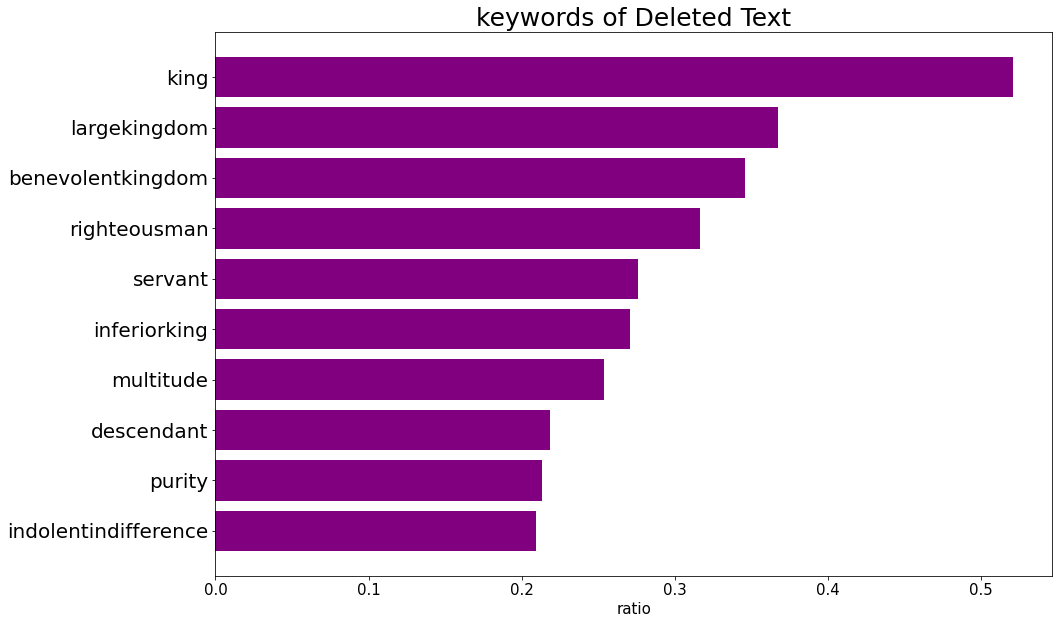

In [21]:
#삭제 부분 전체 Keyword 10개
keywords = kw_model.extract_keywords(preprocessed_deleted, stop_words='english', use_mmr = True, diversity = 0.4, top_n = 10)
print('<Keywords of Deleted Text>')
for k in keywords: print(k)
print('\n\n')
                         
x=np.arange(10)
words = list(reversed([k[0] for k in keywords]))
ratio = list(reversed([k[1] for k in keywords]))

plt.figure(figsize=(15,10))
plt.barh(x, ratio, color='purple')
plt.yticks(x, words, fontsize=20)
plt.xticks(fontsize=15)
plt.xlabel('ratio', fontsize=15)
plt.title('keywords of Deleted Text', fontdict = {'fontsize':25})
plt.show()

### ※ Calculate the number of subheadings of each heading

In [22]:
#무삭제 부분 대분류별 소분류 개수 계산

parts = []
for n in mencius_not_deleted.keys():
  for j in mencius_not_deleted[n].keys():
    part = []  
    for a,b in mencius_not_deleted[n][j].items():
      part.append(a)
    parts.append(part)

parts = [parts[i] + parts[i+1] for i in range(len(parts)) if i%2==0]

len_not_del_parts = [len(parts[i]) for i in range(len(parts))]

for i in range(len(parts)):
  print(f"not deleted subheadings of part{i+1}:", len(parts[i]))

not deleted subheadings of part1: 6
not deleted subheadings of part2: 12
not deleted subheadings of part3: 8
not deleted subheadings of part4: 40
not deleted subheadings of part5: 8
not deleted subheadings of part6: 30
not deleted subheadings of part7: 66


In [23]:
#삭제 부분 대분류별 소분류 개수 계산
parts = []
for n in mencius_deleted.keys():
  for j in mencius_deleted[n].keys():
    part = []  
    for a,b in mencius_deleted[n][j].items():
      part.append(a)
    parts.append(part)

parts = [parts[i] + parts[i+1] for i in range(len(parts)) if i%2==0]

len_del_parts = [len(parts[i]) for i in range(len(parts))]

for i in range(len(parts)):
  print(f"deleted subheadings of part{i+1}:", len(parts[i]))


deleted subheadings of part1: 17
deleted subheadings of part2: 10
deleted subheadings of part3: 7
deleted subheadings of part4: 21
deleted subheadings of part5: 11
deleted subheadings of part6: 5
deleted subheadings of part7: 18


In [24]:
df = pd.DataFrame({"parts":[f"part{i+1}" for i in range(len(len_del_parts))],
             "num_deleted_subheadings":len_del_parts,
              "num_not_deleted_subheadings":len_not_del_parts})

df.index = ['Liang Hui Wang','Gong Sun Chou','Teng Wen Gong','Li Lou','Wan Zhang','Gao Zi','Jin Xin'] # == part1, part2, part3, ..., part7
df["num_subheadings"] = df['num_deleted_subheadings'] + df['num_not_deleted_subheadings']
df["deleted rate per each part(%)"] = round((df['num_deleted_subheadings'] * 100) / df["num_subheadings"], 2)
new_df = df.sort_values("deleted rate per each part(%)", ascending=False)
new_df

,parts,num_deleted_subheadings,num_not_deleted_subheadings,num_subheadings,deleted rate per each part(%)
Liang Hui Wang,part1,17,6,23,73.91
Wan Zhang,part5,11,8,19,57.89
Teng Wen Gong,part3,7,8,15,46.67
Gong Sun Chou,part2,10,12,22,45.45
Li Lou,part4,21,40,61,34.43
Jin Xin,part7,18,66,84,21.43
Gao Zi,part6,5,30,35,14.29


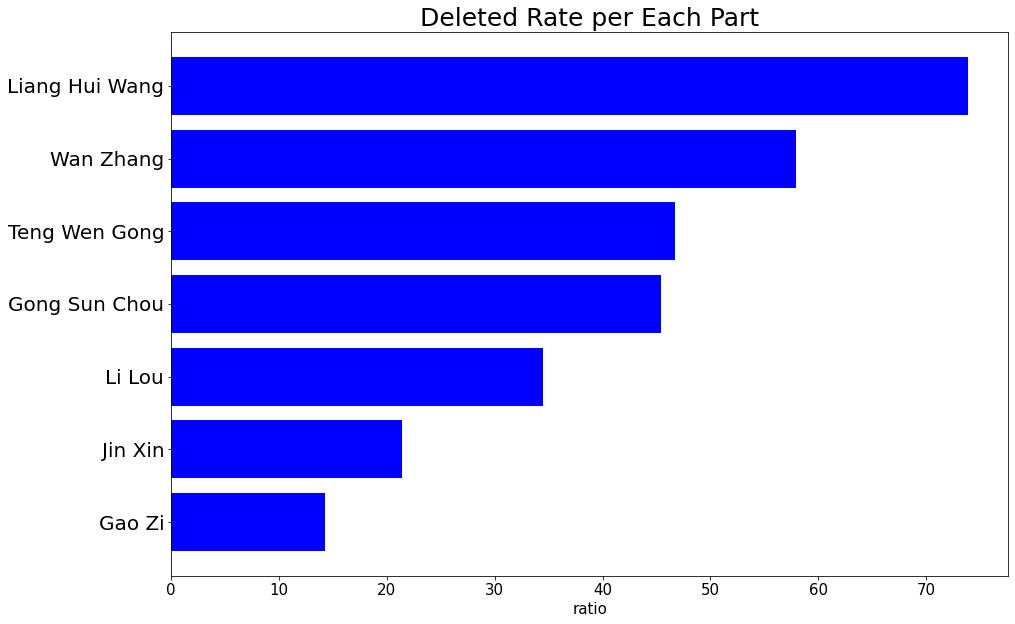

In [25]:
x=np.arange(7)
titles = list(reversed(new_df.index.to_list()))
ratio = list(reversed(new_df['deleted rate per each part(%)'].to_list()))

plt.figure(figsize=(15,10))
plt.barh(x, ratio, color='blue')
plt.yticks(x, titles, fontsize=20)
plt.xticks(fontsize=15)
plt.xlabel('ratio',fontsize=15)
plt.title('Deleted Rate per Each Part', fontdict = {'fontsize':25})
plt.show()

### 2.2.3. KeyBert Topic Modeling - Each Heading of Not Deleted Part of Mencius

In [26]:
#대분류별 무삭제 텍스트 Keyword 10개
for i, not_deleted_txt in enumerate(not_deleted_texts_full) :
  print(f"\nNot Delted Text part {i+1} keyword 10")
  print(kw_model.extract_keywords(not_deleted_txt, stop_words='english', use_mmr = True, diversity = 0.4, top_n = 10))


Not Delted Text part 1 keyword 10
[('kingdom', 0.4729), ('king', 0.4691), ('greatkingdom', 0.2783), ('oldpeople', 0.2066), ('consume', 0.2015), ('fowl', 0.1986), ('virtuousking', 0.1862), ('grain', 0.1801), ('burden', 0.1675), ('select', 0.1558)]

Not Delted Text part 2 keyword 10
[('king', 0.424), ('honourabledignity', 0.3351), ('servant', 0.3061), ('commonpeople', 0.2707), ('surpass', 0.2495), ('convey', 0.221), ('taxis', 0.2117), ('enforce', 0.208), ('distress', 0.1973), ('select', 0.1861)]

Not Delted Text part 3 keyword 10
[('king', 0.4583), ('worthyking', 0.2984), ('successor', 0.2475), ('propersource', 0.2436), ('inferiorofficer', 0.2373), ('mournfulness', 0.232), ('ritual', 0.2299), ('impose', 0.2188), ('greaturgency', 0.2125), ('exert', 0.1713)]

Not Delted Text part 4 keyword 10
[('righteousness', 0.3398), ('sincerity', 0.3076), ('obey', 0.3068), ('distress', 0.2809), ('tranquillity', 0.2643), ('seek', 0.248), ('marry', 0.2377), ('provide', 0.2118), ('narrowlane', 0.1631), (

### 2.2.4. KeyBert Topic Modeling - Each Heading of Deleted Part of Mencius

In [27]:
#대분류별 삭제 텍스트 Keyword 10개
for i, deleted_txt in enumerate(deleted_texts_full) :
  print(f"\nDelted Text part {i+1} keyword 10")
  print(kw_model.extract_keywords(deleted_txt, stop_words='english', use_mmr = True, diversity = 0.4, top_n = 10))


Delted Text part 1 keyword 10
[('king', 0.5207), ('ancientkingdom', 0.3833), ('righteousness', 0.2877), ('servant', 0.2761), ('inferiorking', 0.2711), ('chariot', 0.2659), ('multitude', 0.2541), ('surpass', 0.225), ('fatherless', 0.2239), ('commonpeople', 0.1958)]

Delted Text part 2 keyword 10
[('king', 0.4355), ('royaldignity', 0.392), ('noble', 0.3235), ('attainment', 0.256), ('subordinate', 0.2515), ('tyrannicalkingdom', 0.2344), ('flourish', 0.2298), ('inquire', 0.2109), ('purity', 0.1938), ('indolentindifference', 0.1812)]

Delted Text part 3 keyword 10
[('dynasty', 0.5151), ('king', 0.3821), ('ancientking', 0.2763), ('benevolentkingdom', 0.2723), ('inferiorman', 0.2598), ('hereditary', 0.2458), ('purity', 0.2034), ('repay', 0.1819), ('distress', 0.1742), ('necessarymillet', 0.1591)]

Delted Text part 4 keyword 10
[('kingdom', 0.3723), ('benevolentrule', 0.299), ('instrument', 0.2375), ('superior', 0.2357), ('practise', 0.2294), ('compass', 0.2264), ('flourish', 0.2263), ('examp

# 3. Word Association Analysis

##3.1 Analyzing Word Association of 'king' using Word2Vec
- What words were mentioned about 'king' in each text?

### 3.1.1. Word Association Analysis about 'king' in Not Deleted Part of Mencius

In [32]:
not_deleted_sentences=[word_tokenize(text) for text in not_deleted_texts_full]
word2vec_model = Word2Vec(sentences = not_deleted_sentences, size=100, window=3, min_count=5, workers=5, sg=0)
not_del_king=word2vec_model.wv.most_similar("king")
not_del_king

/usr/local/lib/python3.8/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):


[('people', 0.9650605916976929),
 ('kingdom', 0.9485045671463013),
 ('good', 0.9473914504051208),
 ('benevolence', 0.9463801383972168),
 ('scholar', 0.9459871053695679),
 ('superiorman', 0.9458960294723511),
 ('parent', 0.9448375105857849),
 ('officer', 0.9434173107147217),
 ('sage', 0.9366573095321655),
 ('principle', 0.9352509379386902)]

<ipython-input-35-49c2bd74d1da>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = word2vec_model[vocab]


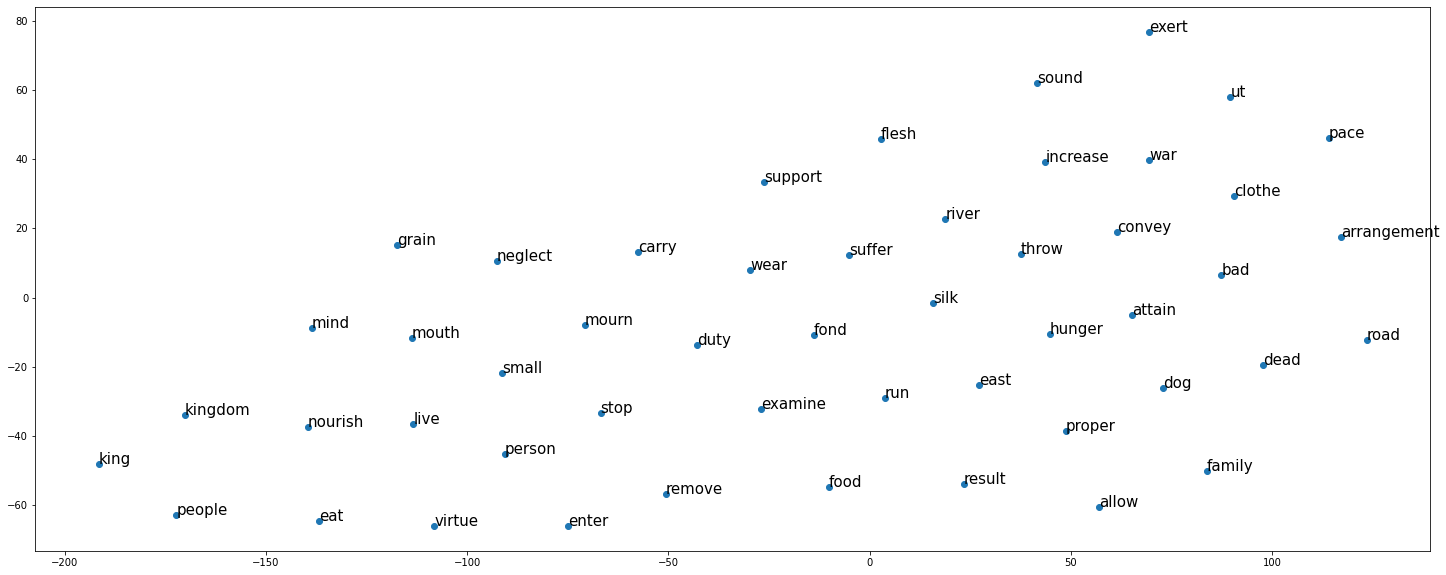

In [35]:
vocab=list(word2vec_model.wv.vocab)
X = word2vec_model[vocab]
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
# 50개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:50,:])
df = pd.DataFrame(X_tsne, index=vocab[:50], columns=['x', 'y'])
fig = plt.figure()
fig.set_size_inches(25, 10)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=15)
plt.show()

### 3.1.2. Word Association Analysis about 'king' in Deleted Part of Mencius

In [30]:
deleted_sentences=[word_tokenize(text) for text in deleted_texts_full]
word2vec_model = Word2Vec(sentences = deleted_sentences, size=100, window=3, min_count=5, workers=5, sg=0)
del_king=word2vec_model.wv.most_similar("king")
del_king

/usr/local/lib/python3.8/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):


[('people', 0.9921383261680603),
 ('kingdom', 0.9908201694488525),
 ('officer', 0.9851366281509399),
 ('scholar', 0.9827916622161865),
 ('hear', 0.9818941950798035),
 ('speak', 0.9793336391448975),
 ('virtue', 0.9792129993438721),
 ('benevolence', 0.978624165058136),
 ('heaven', 0.9781781435012817),
 ('live', 0.9772704839706421)]

<ipython-input-31-49c2bd74d1da>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = word2vec_model[vocab]


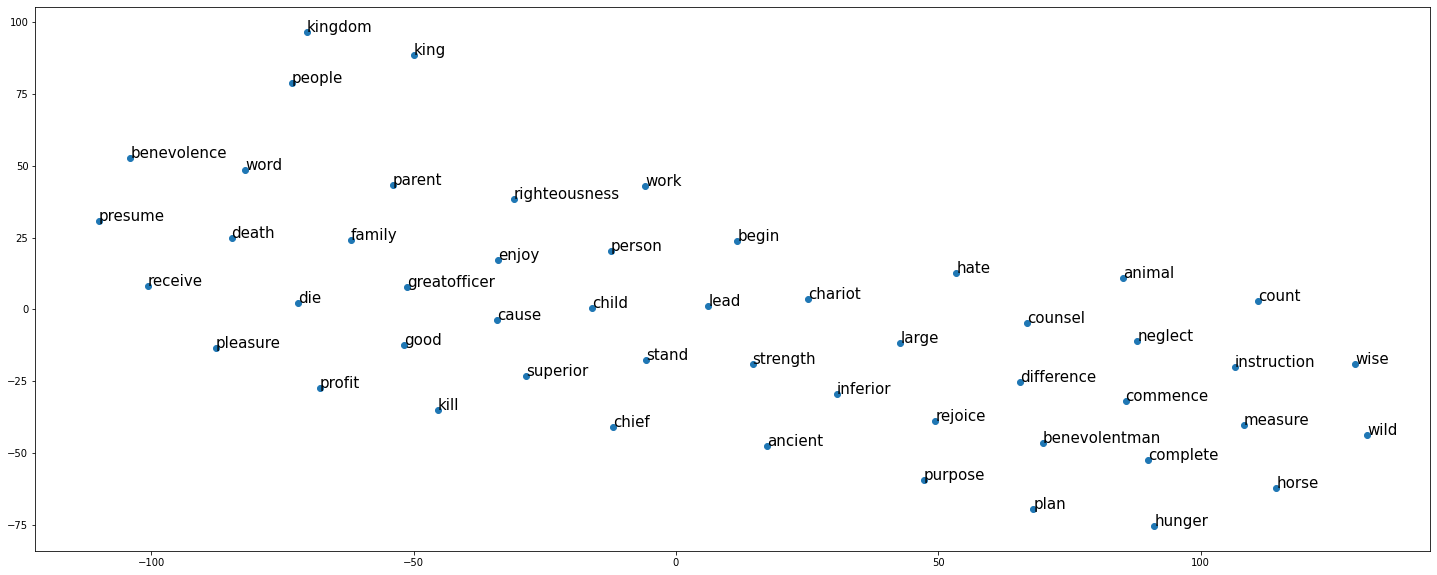

In [31]:
vocab=list(word2vec_model.wv.vocab)
X = word2vec_model[vocab]
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
# 50개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:50,:])
df = pd.DataFrame(X_tsne, index=vocab[:50], columns=['x', 'y'])
fig = plt.figure()
fig.set_size_inches(25, 10)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=15)
plt.show()